# Unsupervised Learning Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.metrics import calinski_harabasz_score, silhouette_score, silhouette_samples
import pickle
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import radar_plotting
from radar_plotting import plot_radar
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',35)
%matplotlib inline

In [2]:
# prelabeled set used for initial training
prelabeled_df = pd.read_csv('../data/finalized_data/training_nocorr')

# unlabeled set used for predictions after initial training
unlabeled_df = pd.read_csv('../data/finalized_data/unlabeled_nocorr')

In [3]:
prelabeled_df.drop('Class', axis=1, inplace=True)
unlabeled_df.drop('Class', axis=1, inplace=True)

In [4]:
prelabeled_df

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,TEAM
0,Aaron Gordon: 2015,78.0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,PF,ORL
1,Al Horford: 2015,82.0,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,C,ATL
2,Al Jefferson: 2015,47.0,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,C,CHA
3,Andre Drummond: 2015,81.0,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,C,DET
4,Andrew Bogut: 2015,70.0,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,C,GSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,Nikola Vucevic: 2020,44.0,34.1,24.5,48.0,6.5,40.6,11.8,3.8,1.9,1.0,0.6,8.5,55.3,5.6,46.0,11.1,3.5,83.0,C,CHI
348,Patty Mills: 2020,40.0,25.6,13.1,44.3,6.9,39.5,1.8,2.6,1.1,0.7,0.0,2.1,57.1,1.3,50.9,0.0,3.8,73.0,PG,SAS
349,Stephen Curry: 2020,39.0,33.7,29.0,47.5,11.4,40.8,5.3,6.2,3.1,1.4,0.1,6.5,60.0,2.3,46.6,0.2,10.2,75.0,PG,GSW
350,Victor Oladipo: 2020,29.0,33.4,20.8,41.1,7.7,33.3,5.0,4.7,2.4,1.3,0.4,8.2,51.2,2.6,29.7,0.0,12.9,76.0,SG,MIA


In [5]:
df = pd.concat([prelabeled_df, unlabeled_df])
df

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,TEAM
0,Aaron Gordon: 2015,78.0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,PF,ORL
1,Al Horford: 2015,82.0,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,C,ATL
2,Al Jefferson: 2015,47.0,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,C,CHA
3,Andre Drummond: 2015,81.0,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,C,DET
4,Andrew Bogut: 2015,70.0,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,C,GSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,Wayne Ellington: 2020,31.0,23.2,10.7,45.8,6.4,43.1,1.8,1.5,0.7,0.4,0.2,1.1,63.6,0.7,40.0,0.0,1.9,76.0,SG,DET
1027,Wendell Carter Jr: 2020,32.0,24.7,10.9,51.2,0.7,36.4,7.8,2.2,1.5,0.6,0.8,5.9,55.9,1.2,38.5,2.5,1.0,82.0,C,ORL
1028,Wesley Matthews: 2020,37.0,20.1,4.5,35.9,3.3,34.7,1.4,1.0,0.5,0.5,0.4,0.6,50.0,0.3,20.0,0.3,1.2,76.0,SG,LAL
1029,Will Barton: 2020,41.0,30.7,12.7,43.5,4.7,37.7,4.1,3.1,1.7,0.9,0.4,5.2,50.0,1.2,41.7,0.0,6.1,78.0,SF,DEN


In [6]:
ss = StandardScaler()

In [7]:
predictors = df.drop(['Player', 'GP', 'TEAM'], axis=1)
predictors = pd.get_dummies(predictors)
predictors

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,0,1,0,0,0
1,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,1,0,0,0,0
2,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,1,0,0,0,0
3,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,1,0,0,0,0
4,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,23.2,10.7,45.8,6.4,43.1,1.8,1.5,0.7,0.4,0.2,1.1,63.6,0.7,40.0,0.0,1.9,76.0,0,0,0,0,1
1027,24.7,10.9,51.2,0.7,36.4,7.8,2.2,1.5,0.6,0.8,5.9,55.9,1.2,38.5,2.5,1.0,82.0,1,0,0,0,0
1028,20.1,4.5,35.9,3.3,34.7,1.4,1.0,0.5,0.5,0.4,0.6,50.0,0.3,20.0,0.3,1.2,76.0,0,0,0,0,1
1029,30.7,12.7,43.5,4.7,37.7,4.1,3.1,1.7,0.9,0.4,5.2,50.0,1.2,41.7,0.0,6.1,78.0,0,0,0,1,0


In [8]:
predictors_no_pos = df.drop(['Player', 'GP', 'TEAM', 'Pos'], axis=1)

In [9]:
predictors_scaled = ss.fit_transform(predictors_no_pos)
predictors_scaled = pd.DataFrame(predictors_scaled, columns=predictors_no_pos.columns)

In [10]:
predictors_scaled

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height
0,-0.878299,-0.735668,0.197616,-0.828947,-0.304096,0.555806,-0.689773,-1.067040,-0.286707,0.317656,-0.287858,0.886198,-0.420338,-0.621926,-0.353804,-0.731458,0.700175
1,0.873664,0.327050,0.725357,-0.249490,0.146117,0.868867,0.114024,-0.447824,-0.286707,1.983316,0.217996,1.462143,1.352387,0.696773,1.089992,-0.753816,0.994325
2,-1.006491,-0.239733,0.395519,-1.631273,-3.080409,0.516674,-0.740010,-1.190884,-0.816455,0.734071,0.684938,-0.477883,1.289076,0.644855,4.473889,-1.223322,0.994325
3,1.044587,0.504170,0.989227,-1.586699,0.042943,3.803806,-1.091671,0.295236,1.567410,1.775108,2.786177,-0.083815,-0.736896,-1.317618,2.082601,-1.022105,1.288476
4,-1.561991,-1.408723,2.737366,-1.631273,6.299028,0.751469,-0.338112,-0.571667,-1.081329,2.191523,-0.482417,1.689490,-1.180077,-0.798445,0.503450,-1.200964,1.582626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,-1.027856,-0.469988,-0.049762,1.221440,0.962128,-1.283422,-0.740010,-1.190884,-1.346203,-0.723382,-1.533036,1.356048,-0.800207,0.239901,-0.624516,-0.798531,-0.770576
1379,-0.707375,-0.434564,0.840800,-1.319258,0.333706,1.064529,-0.388349,-0.200137,-0.816455,0.525863,0.334732,0.189001,-0.483649,0.084149,0.503450,-0.999748,0.994325
1380,-1.690184,-1.568131,-1.682458,-0.160343,0.174255,-1.439953,-0.991197,-1.438570,-1.081329,-0.306967,-1.727595,-0.705230,-1.053454,-1.836790,-0.489160,-0.955033,-0.770576
1381,0.574548,-0.115749,-0.429075,0.463688,0.455639,-0.383374,0.063786,0.047549,-0.021833,-0.306967,0.062349,-0.705230,-0.483649,0.416419,-0.624516,0.140482,-0.182275


In [11]:

k_means_5 = KMeans(n_clusters=5, random_state=17).fit(predictors_scaled)
k_means_6 = KMeans(n_clusters=6, random_state=17).fit(predictors_scaled)
k_means_7 = KMeans(n_clusters=7, random_state=17).fit(predictors_scaled)
k_means_8 = KMeans(n_clusters=8, random_state=17).fit(predictors_scaled)
k_means_9 = KMeans(n_clusters=9, random_state=17).fit(predictors_scaled)
k_means_10 = KMeans(n_clusters=10, random_state=17).fit(predictors_scaled)


k_list = [k_means_5, k_means_6, k_means_7, k_means_8, k_means_9, k_means_10]

In [12]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(predictors_scaled, labels))

In [13]:
sns.set_style('dark')
sns.set_context('talk')

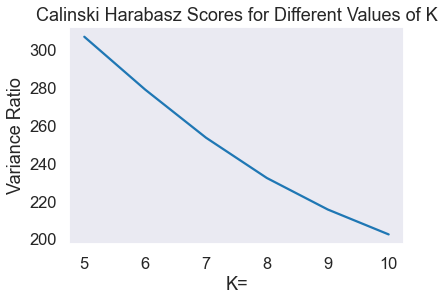

In [14]:
plt.plot([5, 6, 7, 8, 9, 10], CH_score)
plt.xticks([5, 6, 7, 8, 9, 10])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [15]:
wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

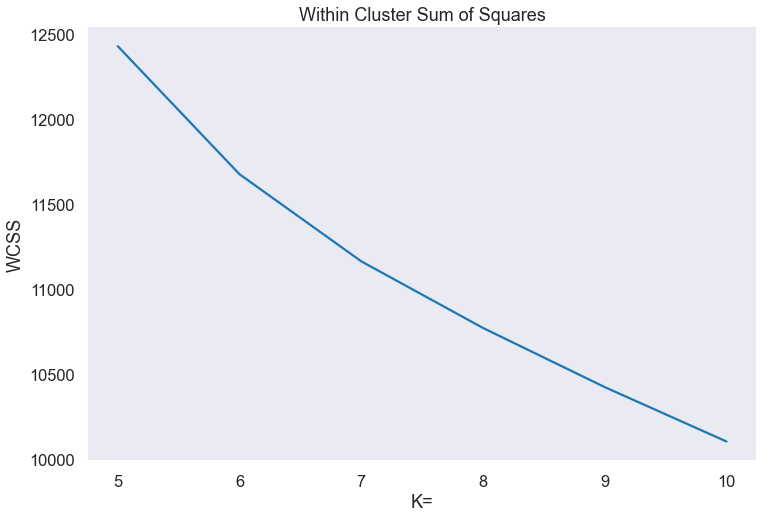

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figsize=(12,8))
plt.plot([5, 6, 7, 8, 9, 10], wcss_score)
plt.xticks([5, 6, 7, 8, 9, 10])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
fig1 = plt.gcf()
plt.show()
plt.draw()
#fig1.savefig('figures/kmeans_WCSS.png')

In [17]:
sil_score = []

for model in k_list:
    labels = model.labels_
    sil_score.append(silhouette_score(predictors_scaled, labels))

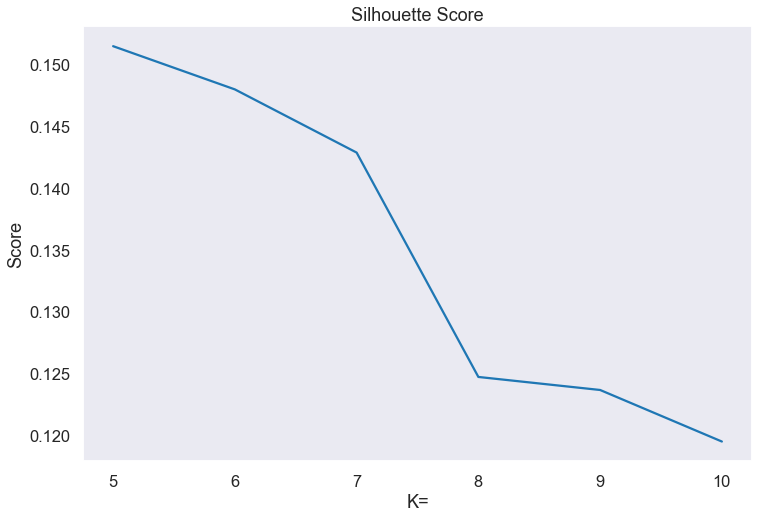

In [18]:
plt.figure(figsize=(12,8))
plt.plot([5, 6, 7, 8, 9, 10], sil_score)
plt.xticks([5, 6, 7, 8, 9, 10])
plt.title('Silhouette Score')
plt.ylabel('Score')
plt.xlabel('K=')
fig2 = plt.gcf()
#fig2.savefig('figures/kmeans_sil.png')

For n_clusters = 5 The average silhouette_score is : 0.1514510248748878
For n_clusters = 6 The average silhouette_score is : 0.14795845847140143
For n_clusters = 7 The average silhouette_score is : 0.14285435687206552
For n_clusters = 8 The average silhouette_score is : 0.12472519304376083
For n_clusters = 9 The average silhouette_score is : 0.12367215327640224
For n_clusters = 10 The average silhouette_score is : 0.11950704385632524


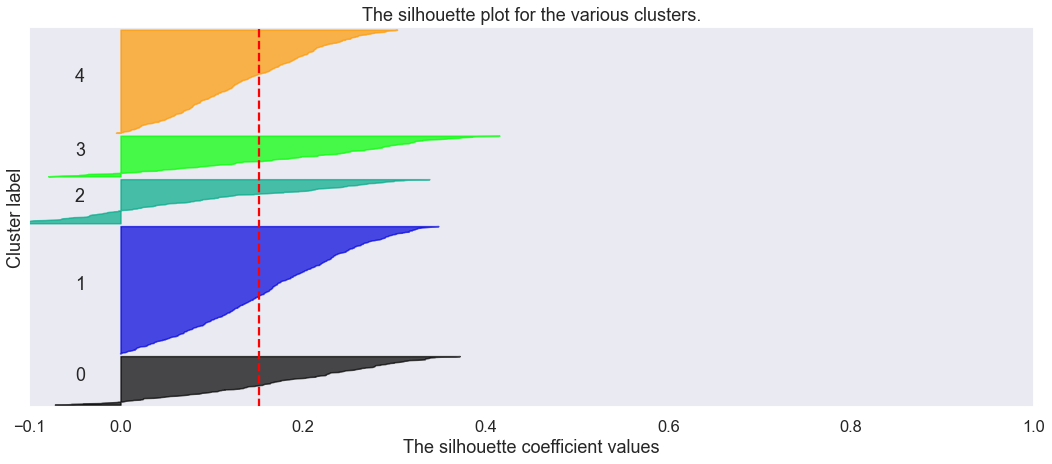

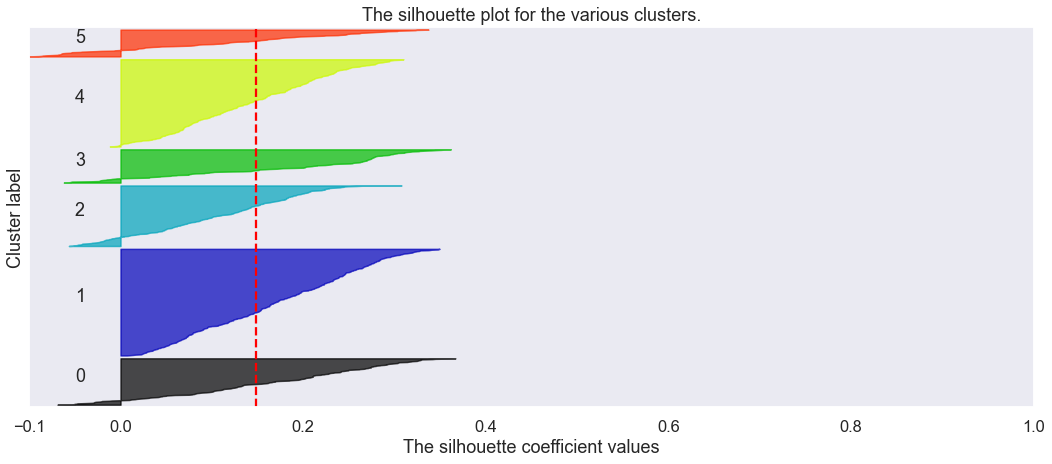

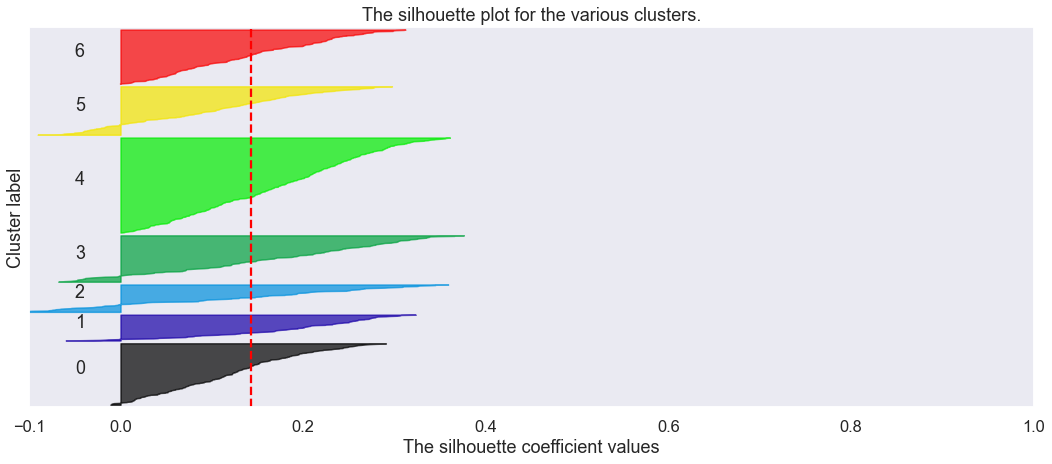

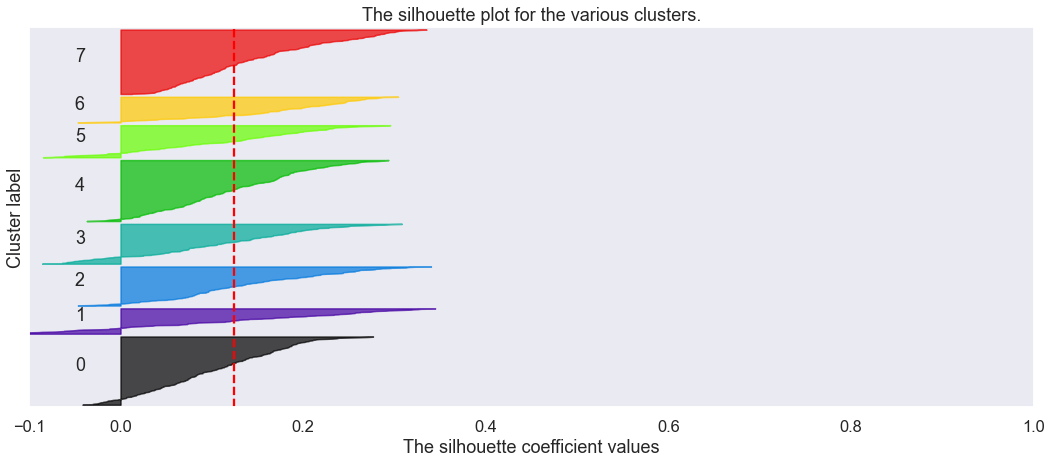

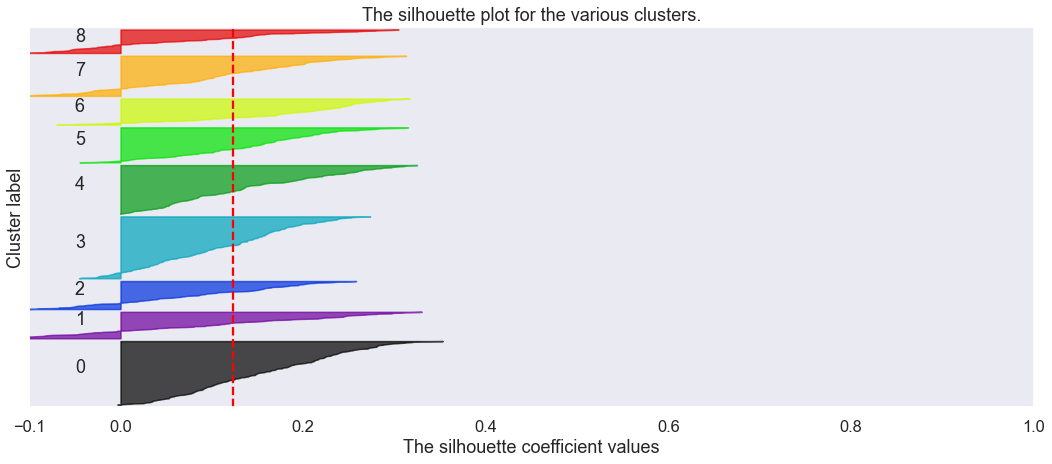

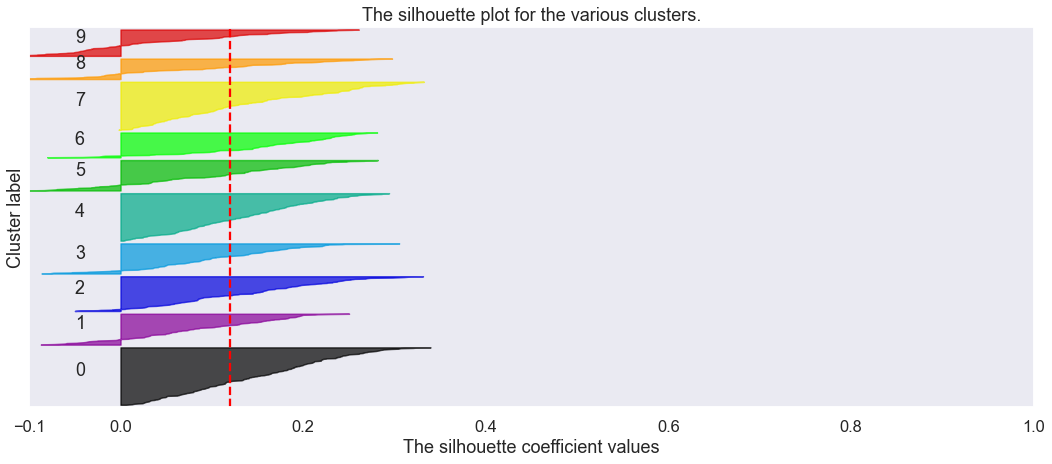

In [19]:
range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(predictors_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=17)
    cluster_labels = clusterer.fit_predict(predictors_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(predictors_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(predictors_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Draw white circles at cluster centers
    

plt.show()

We want the clusters to be greater than 5, which is the number of different positions. Here, it's a toss-up between 6 and 7 clusters. The silhouette score drops from 6 to 7 and then drops sharply after that. Also, with 6 clusters, there are less points with a negative silhouette value, which indicates overlap/uncertainty in classification. I would go with 6 clusters. Let's take a look at the average values for each cluster.

In [14]:
k_means_6.labels_

array([2, 2, 3, ..., 1, 4, 0], dtype=int32)

In [15]:
df['Class']=k_means_6.labels_

#Analyze labels
clusters=pd.DataFrame(columns=(predictors_scaled.columns))
for i in range(6):
    a=df[df['Class']==i].mean()
    clusters=clusters.append(a, ignore_index=True)
    

Let's take a look at each cluster and the average stats for each one

In [22]:
clusters

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Class,GP
0,34.041011,22.383146,45.724719,5.844944,35.789326,5.047191,6.121910,2.916854,1.324157,0.411236,7.633146,54.196629,3.693258,41.898315,0.956742,13.361236,76.140449,0.0,61.792135
1,24.133578,8.740441,42.813235,3.640196,35.826961,3.421569,1.814706,0.999020,0.750245,0.326471,2.629167,53.280392,1.116176,35.953186,0.292402,3.181373,77.946078,1.0,59.965686
2,27.847845,12.771121,48.045259,3.129741,35.673707,6.312500,1.929741,1.415517,0.812069,0.776293,5.230603,57.785345,1.809483,38.339224,2.209052,2.936638,81.310345,2.0,62.892241
3,25.800000,10.664844,58.084375,0.199219,7.489844,8.419531,1.481250,1.383594,0.678125,1.146875,6.499219,61.782813,0.782812,31.597656,2.267187,0.738281,82.781250,3.0,62.921875
4,28.990719,13.317964,43.025150,4.461677,35.595808,3.622455,3.784132,1.817665,0.997605,0.292216,4.672754,50.563473,2.126647,39.183533,0.321557,7.867665,76.083832,4.0,60.260479
5,32.885437,20.790291,50.487379,2.854369,32.124272,9.501942,3.693204,2.510680,1.028155,1.225243,9.053398,58.224272,3.621359,38.557282,6.937864,4.732039,82.563107,5.0,60.844660


At this point, we can determine classifications for these clusters by observing the corresponding statistics

- 0: Ball-Dominant Scorer - "Best" player on a team, main contributor in anything offensive related
- 1: Role Player - Contributes but does not excel in any area
- 2: Stretch Big - Shoots more 3PT and drives in more than a traditional big in exchange for less rebounds
- 3: Traditional Big - Rebounds and blocks shots well, rarely shoots and almost exclusively takes shots inside
- 4: Secondary Guard - Drives and assists with above average 3PT shooting, shortest average height
- 5: High-Usage Big - Scores a lot, rebounds well, takes a lot of shots inside the paint at a high percentage

In [23]:
#pickle.dump(k_means_6, open("models2/kmeans_model.pkl", "wb"))

In [24]:
k_means_6 = pickle.load(open("models2/kmeans_model.pkl", "rb"))

In [25]:
classes = ['Ball-Dominant Scorer', 'Role Player', 'Stretch Big', 'Traditional Big', 'Secondary Guard', 
           'High-Usage Big']

In [28]:
#df.reset_index(drop=True, inplace=True)

Now we want to separate the results by year so we can look at team composition by year

In [29]:
#df.to_csv('results2/kmeans_results.csv', index=False)

In [17]:
df = pd.read_csv('results2/kmeans_results.csv')

In [37]:
df_2015 = df[df['Player'].str.contains('2015')]
df_2016 = df[df['Player'].str.contains('2016')]
df_2017 = df[df['Player'].str.contains('2017')]
df_2018 = df[df['Player'].str.contains('2018')]
df_2019 = df[df['Player'].str.contains('2019')]
df_2020 = df[df['Player'].str.contains('2020')]

df_2015.reset_index(drop=True, inplace=True)
df_2016.reset_index(drop=True, inplace=True)
df_2017.reset_index(drop=True, inplace=True)
df_2018.reset_index(drop=True, inplace=True)
df_2019.reset_index(drop=True, inplace=True)
df_2020.reset_index(drop=True, inplace=True)

Now that we have each year, we can see the team compositions of the top 8, bottom 8, and middle 14 teams in the NBA.

In [38]:
classes = ['Ball-Dominant Scorer', 'Role Player', 'Stretch Big', 'Traditional Big', 'Secondary Guard', 
           'High-Usage Big']

In [72]:
# %load radar_plotting.py
import pandas as pd
import plotly.graph_objects as go

# list of good teams and bad teams (top and bottom 8)
good_2015 = ['GSW', 'SAS', 'CLE', 'TOR', 'OKC', 'LAC', 'ATL', 'BOS']
bad_2015 = ['PHI', 'LAL', 'BKN', 'PHX', 'MIN', 'NOP', 'NYK', 'SAC']

good_2016 = ['GSW', 'SAS', 'HOU', 'BOS', 'CLE', 'LAC', 'TOR', 'UTA']
bad_2016 = ['BKN', 'PHX', 'LAL', 'PHI', 'ORL', 'NYK', 'MIN', 'SAC']

good_2017 = ['HOU', 'TOR', 'GSW', 'BOS', 'PHI', 'CLE', 'POR', 'IND']
bad_2017 = ['PHX', 'MEM', 'DAL', 'ATL', 'ORL', 'SAC', 'CHI', 'BKN']

good_2018 = ['MIL', 'TOR', 'GSW', 'DEN', 'HOU', 'POR', 'PHI','UTA']
bad_2018 = ['NYK', 'PHX', 'CLE', 'CHI', 'ATL', 'WAS', 'NOP', 'MEM']

good_2019 = ['MIL', 'TOR', 'LAL', 'LAC', 'BOS', 'DEN', 'IND', 'HOU']
bad_2019 = ['GSW', 'MIN', 'CLE', 'DET', 'ATL', 'NYK', 'CHI', 'CHA']

good_2020 = ['UTA', 'PHI', 'PHO', 'LAC', 'MIL', 'BKN', 'LAL', 'DEN']
bad_2020 = ['MIN', 'DET', 'ORL', 'HOU', 'WAS', 'CLE', 'TOR', 'OKC']

# This function creates radar plots. Classes refers to a list that contains the names of each player class,
# year refers to the season you want to look at and good/bad/average give you the option of which teams you want
# shown on the radar plot

def plot_radar(df, classes, year=0, good=True, bad=True, average=False):

    top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']
    
    temp = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)
    if year == 0:
        top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']

        temp = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)
        good_df = pd.DataFrame(df_2015[df_2015['TEAM'].isin(good_2015)]['Class'].value_counts().sort_index())
        good_df['Class'] = good_df['Class'] / 8
        #good_df = good_df.drop(0)
        
        bad_df = pd.DataFrame(df_2015[df_2015['TEAM'].isin(bad_2015)]['Class'].value_counts().sort_index())
        bad_df['Class'] = bad_df['Class'] / 8
        #bad_df = bad_df.drop(0)
    
        avg_df = temp.drop(temp[temp['TEAM'].isin(good_2015 + bad_2015)].index)['Class'].value_counts().sort_index()
        avg_df = avg_df / 14
        #avg_df = avg_df.drop(0)
        
        for good_teams,bad_teams, df in zip([good_2016,good_2017,good_2018,good_2019,good_2020],
                       [bad_2016,bad_2017,bad_2018,bad_2019,bad_2020],
                          [df_2016, df_2017, df_2018, df_2019, df_2020]):
            
            top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']
            
            temp = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)

            #good_df_temp = pd.DataFrame(temp[temp['TEAM'].isin(good_teams)]['Class'].value_counts().sort_index())
            good_df_temp = pd.DataFrame(temp[temp['TEAM'].isin(good_teams)]['Class'].value_counts().reindex(
                df.Class.unique(),fill_value=0).sort_index())
            good_df_temp['Class'] = good_df_temp['Class'] / 8
            #good_df_temp = good_df_temp.drop(0)
            good_df['Class'] += good_df_temp['Class']
            
            #bad_df_temp = pd.DataFrame(temp[temp['TEAM'].isin(bad_teams)]['Class'].value_counts().sort_index())
            bad_df_temp = pd.DataFrame(temp[temp['TEAM'].isin(bad_teams)]['Class'].value_counts().reindex(
                df.Class.unique(),fill_value=0).sort_index())
            bad_df_temp['Class'] = bad_df_temp['Class'] / 8
            #bad_df_temp = bad_df_temp.drop(0)
            bad_df['Class'] += bad_df_temp['Class']
            
            #avg_df_temp = temp.drop(temp[temp['TEAM'].isin(good_teams + bad_teams)].index)['Class'].value_counts().sort_index()
            avg_df_temp = temp.drop(temp[temp['TEAM'].isin(good_teams + bad_teams)].index)['Class'].value_counts().reindex(
                df.Class.unique(),fill_value=0).sort_index()
            avg_df_temp = avg_df_temp / 14
            #avg_df_temp = avg_df_temp.drop(0)
            avg_df += avg_df_temp
            
        good_df['Class'] = good_df['Class'] / 6
        bad_df['Class'] = bad_df['Class'] / 6
        avg_df = avg_df / 6
        
    elif year == 2015:
        good_teams = good_2015
        bad_teams = bad_2015
    elif year == 2016:
        good_teams = good_2016
        bad_teams = bad_2016
    elif year == 2017:
        good_teams = good_2017
        bad_teams = bad_2017
    elif year == 2018:
        good_teams = good_2018
        bad_teams = bad_2018
    elif year == 2019:
        good_teams = good_2019
        bad_teams = bad_2019
    elif year == 2020:
        good_teams = good_2020
        bad_teams = bad_2020
    else:
        return "Please enter a year between 2015 and 2020, inclusive"
    
    if year > 0:
        good_df = pd.DataFrame(temp[temp['TEAM'].isin(good_teams)]['Class'].value_counts().sort_index())
        good_df['Class'] = good_df['Class'] / 8
        #good_df = good_df.drop(0)

        bad_df = pd.DataFrame(temp[temp['TEAM'].isin(bad_teams)]['Class'].value_counts().sort_index())
        bad_df['Class'] = bad_df['Class'] / 8
        #bad_df = bad_df.drop(0)
    
        avg_df = temp.drop(temp[temp['TEAM'].isin(good_teams + bad_teams)].index)['Class'].value_counts().sort_index()
        avg_df = avg_df / 14
        #avg_df = avg_df.drop(0)
    
    if year == 0:
        year = "2015-2020"
        
    fig = go.Figure()

    if good:
        fig.add_trace(go.Scatterpolar(
            r=good_df['Class'],
            theta=classes[0:],
              fill='toself',
              name='Good Teams'
        ))
    if bad:
        fig.add_trace(go.Scatterpolar(
            r=bad_df['Class'],
            theta=classes[0:],
              fill='toself',
              name='Bad Teams'
        ))
    if average:
        fig.add_trace(go.Scatterpolar(
            r=avg_df,
            theta=classes[0:],
              fill='toself',
              name='Average Teams'
        ))
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
              visible=True
        )),
    showlegend=True,
    title=f"{year} NBA Team Composition: Unsupervised Model"
    #title=f"{year} NBA Team Composition: Semi-supervised Model"
    )
    fig.show()

In [73]:
plot_radar(df, classes)

In [53]:
plot_radar(df_2015, classes, 2015)

In [52]:
plot_radar(df_2016, classes, 2016)

In [54]:
plot_radar(df_2017, classes, 2017)

In [76]:
plot_radar(df_2018, classes, 2018)

In [77]:
plot_radar(df_2019, classes, 2019)

In [78]:
plot_radar(df_2020, classes, 2020)